In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
from matplotlib.patches import Rectangle, Patch
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [3]:
torch.manual_seed(177013)
np.random.seed(177013)

In [4]:
class Puasson1DPINN(nn.Module):
    def __init__(self, layers, optimizer):
        super(Puasson1DPINN, self).__init__()
        # Creating the hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(in_features=layers[i], out_features=layers[i+1])
            for i in range(len(layers) - 1)
        ])
        # Applying tanh activation and Xavier (Glorot) initialization
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight, gain=nn.init.calculate_gain('tanh'))
            layer.bias.data.fill_(0.01)
        self.optimizer = optimizer

    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = torch.tanh(layer(x))
        # No activation after the last layer
        x = self.hidden_layers[-1](x)
        return x

    def compute_derivatives(self, x):
        x.requires_grad_(True)
        
        u = self.forward(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x_x = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        
        return u, u_x, u_x_x

    def dirichlet_condition(self, x_bc_left_right, u_bc_left_right):
        u, _, _ = self.compute_derivatives(x_bc_left_right)
        return torch.mean((u - u_bc_left_right) ** 2)

    def loss_fn(self, u_x_x, x_train, x_bc_left_right, u_bc_left_right):
        puasson_eq = u_x_x - self.f(x_train)
        bc_dirichlet_left_right = self.dirichlet_condition(x_bc_left_right, u_bc_left_right)
        return torch.mean(puasson_eq ** 2) + 10 * bc_dirichlet_left_right

    def train(self, loss_threshold, x_train, x_bc_left_right, u_bc_left_right):
        loss_array = []
        start_time = time.time()

        loss = torch.tensor(1.)
        epoch = 0

        while loss.item() > loss_threshold:
            self.optimizer.zero_grad()
            u, u_x, u_x_x = self.compute_derivatives(x_train)
            loss = self.loss_fn(u_x_x, x_train, x_bc_left_right, u_bc_left_right)
            loss.backward()
            self.optimizer.step()

            loss_array.append(loss.item())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
            epoch += 1

        print(f"Training took {time.time() - start_time} seconds")
        print(f"Last epoch: {epoch}, loss: {loss.item()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("1d_laplace_equation_training_pytorch.png")
        plt.show()

    def f(self, x):
        # Assuming f(x) returns 0 for now, adjust as necessary
        return torch.zeros_like(x)

    def exact_solution(self, x):
        # Assuming exact solution is -x + 1, adjust as necessary
        return -x + 1

Epoch 0, Loss: 7.861449241638184
Epoch 100, Loss: 0.014562603086233139
Training took 0.3166987895965576 seconds
Last epoch: 108, loss: 0.00964102242141962


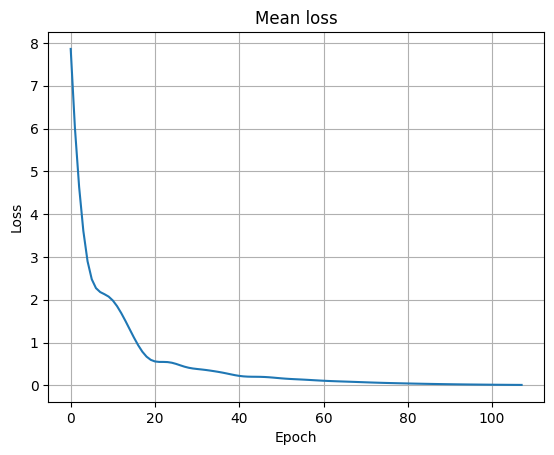

In [5]:
# Setting the number of points for training and testing, the domain boundaries, and Dirichlet boundary conditions
N_of_train_points_1D = 5
N_of_test_points_1D = 101
L_x_1D = 0.0
R_x_1D = 1.0
Dirichlet_left_1D = 1
Dirichlet_right_1D = 0
loss_threshold_1D = 0.01
layers_1D = [1, 10, 10, 10, 1]  # Adjusted to include input and output layer sizes
learning_rate_1D = 0.005

# Converting training and boundary condition inputs to PyTorch tensors
x_train_1D = torch.linspace(L_x_1D, R_x_1D, N_of_train_points_1D).unsqueeze(-1)
x_bc_left_right_1D = torch.tensor([L_x_1D, R_x_1D]).unsqueeze(-1).float()
u_bc_left_right_1D = torch.tensor([Dirichlet_left_1D, Dirichlet_right_1D]).unsqueeze(-1).float()

# Initializing the model and optimizer
model_1D = Puasson1DPINN(layers_1D, None)  # We'll set the optimizer separately
optimizer_1D = optim.Adam(model_1D.parameters(), lr=learning_rate_1D)
model_1D.optimizer = optimizer_1D  # Assigning the optimizer to the model's attribute

# Training the model
model_1D.train(loss_threshold_1D, x_train_1D, x_bc_left_right_1D, u_bc_left_right_1D)

# Computing the exact solution for comparison
U_exact_1D = model_1D.exact_solution(x_train_1D).detach().numpy()

In [6]:
def save_and_load_weights(model_in, layers, file_name, optimizer=None):
    # Save model state dictionary to a file
    torch.save(model_in.state_dict(), f'{file_name}.pth')
    
    # Instantiate a new model with the same layers
    # Note: Ensure the optimizer is properly defined outside of this function or passed in if required
    model_out = Puasson1DPINN(layers, optimizer)
    
    # Load the state dict into the new model
    model_out.load_state_dict(torch.load(f'{file_name}.pth'))
    
    # Create some dummy input and convert it to a PyTorch tensor
    dummy_x_1D = torch.linspace(0, 1, 10).unsqueeze(-1).float()
    
    # Call the model on the dummy input to ensure everything is set up correctly
    # (This step is often not necessary in PyTorch unless specific initialization is done on first call)
    _ = model_out(dummy_x_1D)
    
    return model_out

# Example usage (assuming optimizer is defined elsewhere if needed):
# model_1D_out = save_and_load_weights(model_1D, layers_1D, 'laplace_1d', optimizer_1D)

In [7]:
def calculate_max_relative_error(u_pred, u_exact):
    return 100 * np.linalg.norm(u_exact - u_pred, np.inf) / np.linalg.norm(u_exact, np.inf)

Mean Square Error:  9.605815e-06
Relative error: 0.51%


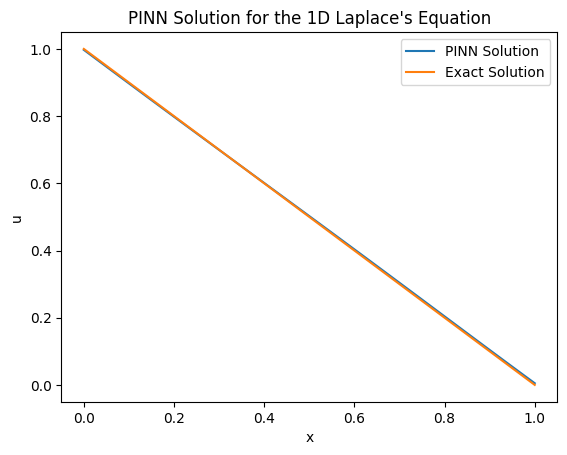

In [8]:
# Convert the test points to a PyTorch tensor
x_test_1D = torch.linspace(L_x_1D, R_x_1D, N_of_test_points_1D).unsqueeze(-1).float()

# The exact solution needs to be calculated with the tensor
U_exact_1D = model_1D.exact_solution(x_test_1D).detach().numpy()

# Prediction using the model. Since we don't have a 'predict' function, we use 'forward' directly.
# Ensure to convert the inputs to tensor if not already and then back to numpy for plotting.
u_pred_1D = model_1D.forward(x_test_1D).detach().numpy()

# Calculating Mean Square Error
mse = np.mean((u_pred_1D - U_exact_1D)**2)
print("Mean Square Error: ", mse)

# Assuming `calculate_max_relative_error` is a function you have defined elsewhere,
# and it operates on numpy arrays or could be easily adapted to.
error_percentage = calculate_max_relative_error(u_pred_1D, U_exact_1D)
print(f"Relative error: {error_percentage:.2f}%")

# Plotting
plt.figure()
plt.plot(x_test_1D.numpy(), u_pred_1D, label='PINN Solution')  # Convert x_test_1D back to numpy for plotting
plt.plot(x_test_1D.numpy(), U_exact_1D, label='Exact Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.title("PINN Solution for the 1D Laplace's Equation")
plt.legend()
plt.savefig("1d_laplace_equation_approx_exact_solution_pytorch.png")
plt.show()

In [9]:
class Puasson2DPINN(nn.Module):
    def __init__(self, layers, optimizer=None):
        super(Puasson2DPINN, self).__init__()
        # Define the hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.hidden_layers.append(nn.Linear(layers[i-1], layers[i]))
        
        # Initialize weights with Glorot normal initialization (Xavier normal in PyTorch)
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.constant_(layer.bias, 0)

        self.optimizer = optimizer

    def forward(self, x1_x2):
        for layer in self.hidden_layers[:-1]:
            x1_x2 = torch.tanh(layer(x1_x2))
        x1_x2 = self.hidden_layers[-1](x1_x2)  # No activation after the last layer
        return x1_x2

    def compute_derivatives(self, x1_x2):
        x1_x2.requires_grad_(True)
        
        u = self.forward(x1_x2)
        grads = torch.autograd.grad(u, x1_x2, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
        u_x1, u_x2 = grads[:, 0], grads[:, 1]
        u_x1_x1 = torch.autograd.grad(u_x1, x1_x2, grad_outputs=torch.ones_like(u_x1), create_graph=True)[0][:, 0]
        u_x2_x2 = torch.autograd.grad(u_x2, x1_x2, grad_outputs=torch.ones_like(u_x2), create_graph=True)[0][:, 1]
        
        return u, u_x1, u_x2, u_x1_x1, u_x2_x2

    def dirichlet_condition(self, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down):
        u_up, _, _, _, _ = self.compute_derivatives(x1_x2_bc_up)
        u_down, _, _, _, _ = self.compute_derivatives(x1_x2_bc_down)
        return torch.mean((u_up - u_bc_up) ** 2) + torch.mean((u_down - u_bc_down) ** 2)

    def neuman_condition(self, x1_x2_bc_left_right):
        _, u_x1, _, _, _ = self.compute_derivatives(x1_x2_bc_left_right)
        return torch.mean(u_x1 ** 2)  # Assuming a simple Neumann condition for demonstration

    def loss_fn(self, x1_x2_train, u_x1_x1, u_x2_x2, x1_x2_bc_left_right, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down):
        puasson_eq = u_x1_x1 + u_x2_x2 - self.f(x1_x2_train)
        bc_dirichlet = self.dirichlet_condition(x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down)
        bc_neuman = self.neuman_condition(x1_x2_bc_left_right)
        return torch.mean(puasson_eq ** 2) + 5 * (bc_dirichlet + bc_neuman)  # Adjust weights as needed

    def train_loop(self, loss_threshold, x1_x2_train, x1_x2_bc_left_right, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down):
        loss_array = []
        start_time = time.time()

        loss = torch.tensor(1.)
        epoch = 0

        while loss.item() > loss_threshold:
            self.optimizer.zero_grad()
            u, u_x1, u_x2, u_x1_x1, u_x2_x2 = self.compute_derivatives(x1_x2_train)
            loss = self.loss_fn(x1_x2_train, u_x1_x1, u_x2_x2, x1_x2_bc_left_right, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down)
            loss.backward()
            self.optimizer.step()

            loss_array.append(loss.item())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
            epoch += 1

        print(f"Training took {time.time() - start_time} seconds")
        print(f"Last epoch: {epoch}, loss: {loss.item()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("2d_laplace_equation_training_pytorch.png")
        plt.show(block=False)

    def f(self, x1_x2):
        # Assuming f(x) returns 0 for now, adjust as necessary
        return torch.zeros(x1_x2.shape[0], 1)

    def exact_solution(self, x1_x2):
        # Assuming the exact solution is a simple function of x1 for demonstration purposes
        return -x1_x2[:, 0] + 1

Epoch 0, Loss: 4.313003063201904
Epoch 100, Loss: 0.03652205690741539
Training took 0.9134259223937988 seconds
Last epoch: 142, loss: 0.009736217558383942


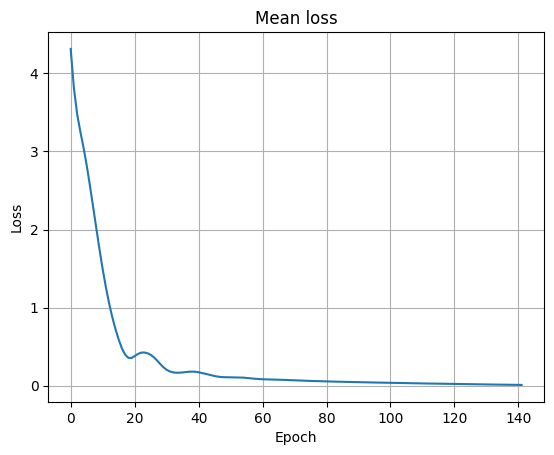

In [10]:
# Define the problem parameters
N_of_train_points_2D = 5
N_of_test_points_2D = 101
L_x1_2D = 0.0
R_x1_2D = 1.0
L_x2_2D = 0.0
R_x2_2D = 1.0
Dirichlet_up_2D = 0
Dirichlet_down_2D = 1
loss_threshold_2D = 0.01
layers_2D = [2, 10, 10, 10, 1]  # Adjusted to include the input layer size for 2D input
learning_rate_2D = 0.005

# Initialize the model
model_2D = Puasson2DPINN(layers_2D)
optimizer_2D = optim.Adam(model_2D.parameters(), lr=learning_rate_2D)
model_2D.optimizer = optimizer_2D  # Set the optimizer

# Prepare the training data
x1_train = np.linspace(L_x1_2D, R_x1_2D, N_of_train_points_2D)
x2_train = np.linspace(L_x2_2D, R_x2_2D, N_of_train_points_2D)
x1_mesh, x2_mesh = np.meshgrid(x1_train, x2_train)
x1_x2_train = np.hstack((x1_mesh.flatten()[:, np.newaxis], x2_mesh.flatten()[:, np.newaxis]))

# Convert training data to torch tensors
x1_x2_train = torch.tensor(x1_x2_train, dtype=torch.float32)

# Prepare boundary condition data
# bc - boundary condition (left and right) neuman
#         __________________________
#         ||                       ||
# [-1, 0] || x2                    || [1, 0] 
#         ||          x1           ||
#         ||_______________________||
# ∂u/∂n = -∂u/∂x1                      ∂u/∂n = ∂u/∂x1
x1_bc_left_right = np.concatenate((L_x1_2D * np.ones_like(x2_train), R_x1_2D * np.ones_like(x2_train)))
x2_bc_left_right = np.concatenate((x2_train, x2_train))
x1_x2_bc_left_right = torch.tensor(np.hstack((x1_bc_left_right[:, np.newaxis], x2_bc_left_right[:, np.newaxis])), dtype=torch.float32)

# bc - boundary condition (up and down) dirichlet
#          [0, 1]  ∂u/∂n = ∂u/∂x2
#  =======================
# |                       |
# | x2                    |
# |          x1           |
# |=======================|
#          [0, -1]  ∂u/∂n = -∂u/∂x2
x2_bc_up = R_x2_2D * np.ones_like(x1_train)
x2_bc_down = L_x2_2D * np.ones_like(x1_train)
x1_x2_bc_up = torch.tensor(np.hstack((x1_train[:, np.newaxis], x2_bc_up[:, np.newaxis])), dtype=torch.float32)
x1_x2_bc_down = torch.tensor(np.hstack((x1_train[:, np.newaxis], x2_bc_down[:, np.newaxis])), dtype=torch.float32)

u_bc_up = Dirichlet_up_2D * np.ones_like(x1_train)
u_bc_down = Dirichlet_down_2D * np.ones_like(x1_train)
u_bc_up = torch.tensor(u_bc_up, dtype=torch.float32).unsqueeze(1)
u_bc_down = torch.tensor(u_bc_down, dtype=torch.float32).unsqueeze(1)

# Train the model
# Note: The `train_loop` method does not exist by default in PyTorch models. Assuming it is meant to be the `train` method from earlier.
model_2D.train_loop(loss_threshold_2D, x1_x2_train, x1_x2_bc_left_right, x1_x2_bc_up, x1_x2_bc_down, u_bc_up, u_bc_down)

In [11]:
def save_and_load_model(model, layers):
    # Assuming `model` is an instance of Puasson2DPINN or any torch.nn.Module
    
    # Save model state to file
    torch.save(model.state_dict(), 'pinn_wave_equation_model.pth')

    # Instantiate a new model with the same configuration
    new_model = Puasson2DPINN(layers=layers, optimizer=None)  # You'll need to set the optimizer later as needed

    # Load the model state from the saved file
    new_model.load_state_dict(torch.load('pinn_wave_equation_model.pth'))
    
    # Ensure the new model is in evaluation mode if you're going to use it for predictions right away
    new_model.eval()

    return new_model

# Example usage:
# Assuming `model` is your pre-trained model instance and `layers` is the list of layer sizes
# new_model = save_and_load_model(model, layers)

In [12]:
#Assume x1_test, x2_test are NumPy arrays as defined in the original snippet
x1_test = np.linspace(L_x1_2D, R_x1_2D, N_of_test_points_2D)[:, np.newaxis]
x2_test = np.linspace(L_x2_2D, R_x2_2D, N_of_test_points_2D)[:, np.newaxis]
x1_mesh, x2_mesh = np.meshgrid(x1_test, x2_test)
x1x2_test = np.hstack((x1_mesh.flatten()[:, np.newaxis], x2_mesh.flatten()[:, np.newaxis]))

# Convert input to PyTorch tensor
x1x2_test_tensor = torch.tensor(x1x2_test, dtype=torch.float32)

# Predict with PyTorch model (assuming model_2D is your PyTorch model)
u_pred_2D = model_2D(x1x2_test_tensor).detach().numpy().reshape(x1_test.shape[0], x2_test.shape[0])

index_x1_05 = np.argmin(np.abs(x1_test - (L_x1_2D + R_x1_2D)/2))

# Extract the values along the line x1 = (L_x1_2D + R_x1_2D)/2
u_pred_1D_05 = u_pred_2D[:, index_x1_05]  # Assuming u_pred is 2D with shape (len(x2_test), len(x_test))

# Calculate the MSE for 1D exact and 2D middle of interval [L_x1_2D, R_x1_2D]
mse_1D = np.mean((u_pred_1D_05 - U_exact_1D.squeeze())**2)
print(f"Mean Square Error for 1D exact and 2D middle of interval [{L_x1_2D}, {R_x1_2D}]: {mse_1D}")

error_percentage_2D = calculate_max_relative_error(u_pred_1D_05, U_exact_1D.squeeze())
print(f"Error based on max difference for 1D exact and 2D middle of interval [{L_x1_2D}, {R_x1_2D}]: {error_percentage_2D:.2f}%")

# U_exact_2D = model_2D.exact_solution(x1x2_test)

# error_percentage_2D = calculate_max_relative_error(u_pred_2D.flatten(), U_exact_2D)
# print(f"Error based on max difference for 2D exact and 2D PINN [{L_x1_2D}, {R_x1_2D}]: {error_percentage_2D:.2f}%")

Mean Square Error for 1D exact and 2D middle of interval [0.0, 1.0]: 6.849073997727828e-06
Error based on max difference for 1D exact and 2D middle of interval [0.0, 1.0]: 0.52%


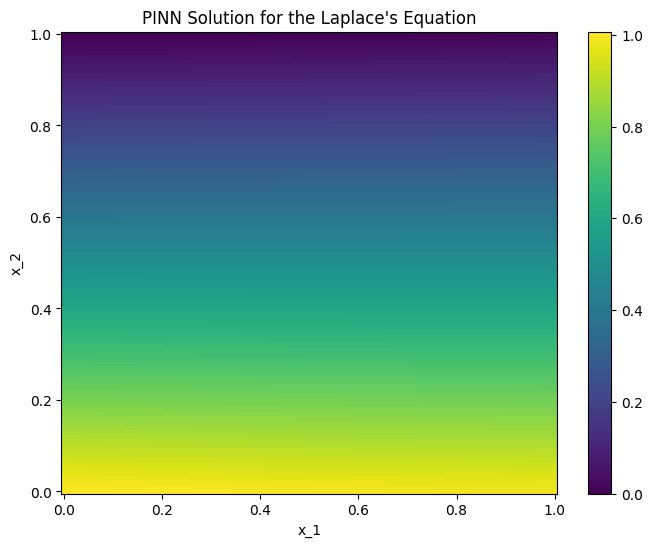

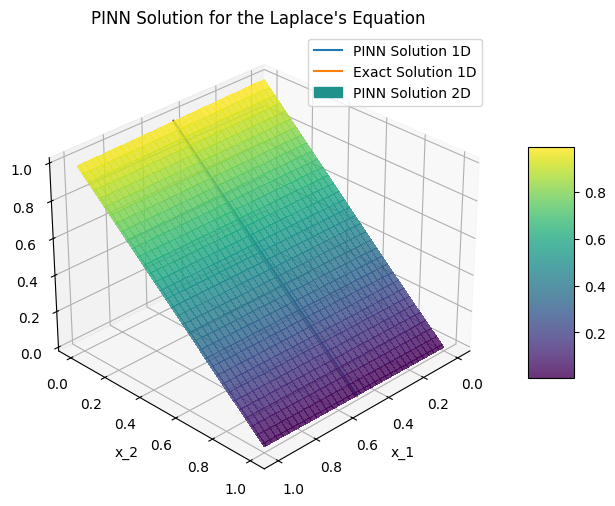

In [51]:
# Sample data (replace this with your actual data)
# x1_mesh = np.linspace(0, 1, 10)
# x2_mesh = np.linspace(0, 1, 10)
# u_pred_2D = np.random.rand(10, 10)
# N_of_test_points_1D = 10
# x_test_1D = np.linspace(0, 1, N_of_test_points_1D)
# u_pred_1D = np.random.rand(N_of_test_points_1D)
# U_exact_1D = np.random.rand(N_of_test_points_1D)

plt.figure(figsize=(8, 6))
plt.pcolor(x1_mesh, x2_mesh, u_pred_2D, cmap='viridis')
plt.colorbar()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title("PINN Solution for the Laplace's Equation")
plt.show(block=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

x_1d_combined = np.ones(N_of_test_points_1D) * 0.5

surf = ax.plot_surface(x1_mesh, x2_mesh, u_pred_2D, cmap='viridis', linewidth=0, antialiased=False, label='PINN Solution 2D', zorder=0, alpha=0.8)
line,  = ax.plot(x_1d_combined, x_test_1D.numpy(), u_pred_1D.flatten(), label='PINN Solution 1D', zorder=2)
line2, = ax.plot(x_1d_combined, x_test_1D.numpy(), U_exact_1D.flatten(), label='Exact Solution 1D', zorder=1)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('u')
ax.set_title("PINN Solution for the Laplace's Equation")

color_for_legend = cm.viridis(0.5)
proxy_surf = Patch(color=color_for_legend, label='PINN Solution 2D')
ax.legend([line, line2, proxy_surf], ['PINN Solution 1D', 'Exact Solution 1D', 'PINN Solution 2D'])

fig.colorbar(surf, shrink=0.5, aspect=5)

# Set the view angle here
ax.view_init(elev=30, azim=45)

plt.show()